# Imports

In [35]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Preprocessing Pipeline

1. Load in the metadata csv
2. create numpy arrays from the data
3. section the data that you are gonna be working on, will try 10 classes first
4. convert those to mel spectrograms only
5. feed into a cnn model

In [2]:
md_raw = pd.read_csv('C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_metadata.csv') # raw metadata
interested_species = [
    'carcha1', 'grecor', 'colsun2', 'categr', 'fotdro5', 'wbrcha2', 'lawgol'
]
md_filtered = md_raw[md_raw['primary_label'].isin(interested_species)] # filtered metadata with interested species (chosen due to similar duration of total auddio samples)

In [3]:
md_filtered['primary_label'].value_counts()

primary_label
colsun2    181
categr     166
carcha1    153
grecor     138
fotdro5    137
wbrcha2    132
lawgol      68
Name: count, dtype: int64

### Removing duplicates within classes

In [4]:
path = 'C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio/'
sr = 16000 # sample rate

In [5]:
# Function to get audio duration
def audioduration(file_path, sr=sr):
  audio, _ = librosa.load(file_path, sr=sr)
  return librosa.get_duration(y=audio, sr=sr)

In [6]:
durations = []
for index, row in tqdm(md_filtered.iterrows(), total=len(md_filtered), desc="Processing durations"):
  filename = row['filename']
  duration = audioduration(path + filename)
  durations.append(duration)

md_filtered['duration'] = durations

Processing durations: 100%|██████████| 975/975 [00:49<00:00, 19.80it/s]
C:\Users\thato\AppData\Local\Temp\ipykernel_11056\968809220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_filtered['duration'] = durations


In [7]:
md_filtered = md_filtered.drop_duplicates(subset=['duration', 'latitude', 'type', 'primary_label', 'author'], keep='first')

# Splitting the data into training and testing

In [8]:
train, test = train_test_split(md_filtered, test_size=0.3, random_state=6669)

# Drop the unused colums

In [9]:
column_delete = ['secondary_labels', 'scientific_name', 'common_name', 'author', 'license', 'url', 'latitude', 'longitude']
train.drop(column_delete, axis=1, inplace=True)
test.drop(column_delete, axis=1, inplace=True)

# Standardize 'type' column

Allowed types: call, song, both

In [10]:
train.loc[train['type'].str.contains('call') & train['type'].str.contains('song'), 'type'] = 'both'
train.loc[train['type'].str.contains('call'), 'type'] = 'call'
train.loc[train['type'].str.contains('song'), 'type'] = 'song'
train.loc[(train['type'] != ('call')) & (train['type'] != ('song')) & (train['type'] != ('both')), 'type'] = 'blank'

test.loc[test['type'].str.contains('call') & test['type'].str.contains('song'), 'type'] = 'both'
test.loc[test['type'].str.contains('call'), 'type'] = 'call'
test.loc[test['type'].str.contains('song'), 'type'] = 'song'
test.loc[(test['type'] != ('call')) & (test['type'] != ('song')) & (test['type'] != ('both')), 'type'] = 'blank'

# Extracting the numpy array objects

In [11]:
# Function to load audio
def extract_audio(filename, sr=16000):
  filepath = 'C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio/' + filename
  audio, _ = librosa.load(filepath, sr=sr)
  return audio

In [12]:
# Function to save the audio as np arrays
def save_audio_np(filenames, is_train):
    folder_dir = 'C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy/' if is_train else 'C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy/'
    os.makedirs(folder_dir, exist_ok=True)  # Use exist_ok=True to avoid errors if the folder exists
    filepaths = []

    # Loop over the filenames, extract the np objects, and save them to the respective directory
    for filename in tqdm(filenames, desc="Saving audio files", unit="file"):
        audio = extract_audio(filename)
        folder = filename.split('/')[0]
        name = filename.split('/')[1]
        new_filename = name.replace('.ogg', '.npy')
        filepaths.append(f'{folder}/{new_filename}')

        # Create save directory
        save_dir = f'{folder_dir}/{folder}/'
        os.makedirs(save_dir, exist_ok=True)
        save_filename = f'{save_dir}{new_filename}'

        # Check if the file already exists
        if os.path.exists(save_filename):
            print(f"File {save_filename} already exists. Skipping...")
            continue  # Skip the current iteration if the file exists

        # Save .npy object
        np.save(save_filename, audio)

    # Assert all filenames have been looped through, and all files have been saved
    assert len(filenames) == len(filepaths)
    return filepaths

In [13]:
train_filepaths = save_audio_np(train['filename'], is_train=True)

Saving audio files:   1%|          | 5/679 [00:00<00:13, 49.04file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC205903.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC578852.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC669289.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC578632.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC118434.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:   1%|▏         | 10/679 [00:00<00:16, 40.30file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC529787.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC623267.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC442302.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC524297.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC418722.npy already exists. Skipping...


Saving audio files:   3%|▎         | 18/679 [00:02<01:36,  6.88file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC127909.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516807.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC756274.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC384921.npy already exists. Skipping...


Saving audio files:   4%|▍         | 26/679 [00:02<00:53, 12.29file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC513153.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC520659.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC726669.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC57418.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC298914.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy

Saving audio files:   4%|▍         | 30/679 [00:02<00:47, 13.74file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC431170.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC282494.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC326411.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC497602.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC196080.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:   6%|▌         | 39/679 [00:02<00:29, 21.95file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC620984.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC756267.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC348343.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC713110.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC755891.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:   6%|▋         | 43/679 [00:03<00:26, 24.22file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC322747.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517344.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC412171.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC577966.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC340915.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:   8%|▊         | 52/679 [00:03<00:24, 25.80file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC428935.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC339720.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC657605.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC365415.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC663646.npy already exists. Skipping...


Saving audio files:   9%|▉         | 60/679 [00:03<00:22, 27.71file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC661808.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC315994.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC128314.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC317506.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC503801.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  10%|▉         | 66/679 [00:03<00:19, 31.18file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC161317.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC345100.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC377503.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC361546.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC367241.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  10%|█         | 71/679 [00:03<00:17, 34.97file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516860.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC423135.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC281998.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC205445.npy already exists. Skipping...


Saving audio files:  12%|█▏        | 80/679 [00:04<00:17, 33.35file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC246911.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC213142.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC633924.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC430661.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC712460.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  13%|█▎        | 88/679 [00:04<00:19, 30.73file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC192966.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC633730.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC485246.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC722334.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC305938.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  14%|█▍        | 97/679 [00:04<00:19, 30.53file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC320852.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC502783.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC756293.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC661815.npy already exists. Skipping...


Saving audio files:  15%|█▍        | 101/679 [00:04<00:19, 30.28file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC664387.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC465551.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC153532.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC444916.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC153585.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audi

Saving audio files:  16%|█▌        | 110/679 [00:05<00:18, 31.34file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC402703.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC163960.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC368934.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC664389.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC282012.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  17%|█▋        | 114/679 [00:05<00:18, 30.32file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC430018.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC513154.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC324664.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC363961.npy already exists. Skipping...


Saving audio files:  17%|█▋        | 118/679 [00:05<00:21, 25.70file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC196510.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC161310.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC515311.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC328548.npy already exists. Skipping...


Saving audio files:  18%|█▊        | 124/679 [00:06<00:28, 19.64file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC622701.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC641788.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC650228.npy already exists. Skipping...


Saving audio files:  19%|█▉        | 128/679 [00:06<00:24, 22.61file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC511796.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC458429.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC523506.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC584723.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC740802.npy already exists. Skipping...


Saving audio files:  20%|█▉        | 134/679 [00:06<00:29, 18.54file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC196079.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC254833.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC661811.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC321214.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC326978.npy already exists. Skipping...


Saving audio files:  20%|██        | 137/679 [00:08<01:35,  5.65file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC627838.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC329275.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC418997.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC692509.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC521923.npy already exists. Skipping...


Saving audio files:  21%|██        | 141/679 [00:08<01:25,  6.31file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC297698.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517333.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC394501.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC453896.npy already exists. Skipping...


Saving audio files:  22%|██▏       | 147/679 [00:08<01:01,  8.66file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC339758.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC442068.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC538792.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC488564.npy already exists. Skipping...


Saving audio files:  22%|██▏       | 151/679 [00:09<00:44, 11.87file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517247.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC461552.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC670929.npy already exists. Skipping...


Saving audio files:  23%|██▎       | 154/679 [00:09<00:48, 10.83file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516601.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC308865.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC649916.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC756271.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC515308.npy already exists. Skipping...


Saving audio files:  24%|██▎       | 160/679 [00:09<00:37, 14.01file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC328546.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC254686.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC665429.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC205895.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC716185.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  25%|██▌       | 173/679 [00:10<00:21, 23.34file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC515309.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516538.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC368935.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC522801.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC713118.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  27%|██▋       | 182/679 [00:10<00:16, 30.31file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC386388.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC468238.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC740311.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC517417.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC613619.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  28%|██▊       | 189/679 [00:10<00:28, 17.21file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC710128.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC39422.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC527808.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517241.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC537447.npy already exists. Skipping...


Saving audio files:  29%|██▉       | 200/679 [00:11<00:16, 28.25file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC352659.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC254665.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC634153.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC494665.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC215126.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  30%|███       | 204/679 [00:11<00:18, 25.51file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC322337.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517237.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC652323.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC501479.npy already exists. Skipping...


Saving audio files:  31%|███       | 208/679 [00:11<00:18, 25.92file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC45473.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517310.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC452604.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC268271.npy already exists. Skipping...


Saving audio files:  32%|███▏      | 217/679 [00:11<00:15, 30.76file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC505929.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC606054.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC503799.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC315415.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC756913.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  33%|███▎      | 226/679 [00:12<00:14, 32.33file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC194274.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC27183.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC342703.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC398521.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC147048.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  34%|███▍      | 232/679 [00:12<00:11, 38.89file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC523448.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC200978.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC579005.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC734540.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC207388.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  36%|███▌      | 244/679 [00:12<00:10, 42.93file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC692762.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC489307.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC274824.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC429102.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC419845.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  37%|███▋      | 254/679 [00:12<00:10, 38.93file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC264285.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC540724.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC307176.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC143799.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC332716.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  39%|███▊      | 262/679 [00:12<00:11, 37.38file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC323326.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC514168.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC371472.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC397798.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC458426.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  39%|███▉      | 267/679 [00:13<00:11, 37.17file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC590128.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC139952.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC189022.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516560.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC142885.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  41%|████      | 278/679 [00:13<00:09, 43.12file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC432984.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC679852.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC323385.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC447483.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC143596.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_np

Saving audio files:  42%|████▏     | 288/679 [00:13<00:09, 40.13file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC461437.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC380247.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC750894.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC453526.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC537026.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  44%|████▍     | 298/679 [00:13<00:09, 38.28file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC640726.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC690082.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC634150.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC604507.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC194472.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  45%|████▍     | 303/679 [00:14<00:16, 22.32file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC642426.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC412266.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC624539.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516994.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC405114.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  46%|████▌     | 312/679 [00:14<00:14, 25.48file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC464810.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC18224.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC536502.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC756266.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC622282.npy already exists. Skipping...


Saving audio files:  47%|████▋     | 321/679 [00:14<00:12, 28.28file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC666599.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC656718.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC45477.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC661825.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC213652.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_np

Saving audio files:  48%|████▊     | 328/679 [00:15<00:23, 14.78file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC661823.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC459158.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC142225.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC326835.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC715717.npy already exists. Skipping...


Saving audio files:  50%|████▉     | 339/679 [00:16<00:14, 23.37file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC143600.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC313340.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC559368.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC617123.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC607698.npy already exists. Skipping...


Saving audio files:  51%|█████▏    | 348/679 [00:16<00:11, 29.30file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC435771.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC566765.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC353848.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC592853.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC682210.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  52%|█████▏    | 352/679 [00:16<00:11, 28.60file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC127460.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC649917.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC353850.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517249.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC600235.npy already exists. Skipping...


Saving audio files:  53%|█████▎    | 359/679 [00:16<00:13, 22.92file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC517604.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC309839.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC268275.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC307104.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC748951.npy already exists. Skipping...


Saving audio files:  54%|█████▎    | 364/679 [00:16<00:11, 27.70file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC322331.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC524802.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC286540.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC541185.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC623079.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audi

Saving audio files:  55%|█████▌    | 376/679 [00:17<00:08, 34.92file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC667525.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC267150.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC429427.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC631387.npy already exists. Skipping...


Saving audio files:  56%|█████▌    | 381/679 [00:17<00:08, 35.52file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC663647.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC652464.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517357.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC452088.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC194473.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  57%|█████▋    | 388/679 [00:17<00:07, 41.19file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC399999.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC26215.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC634200.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC601846.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC304257.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_np

Saving audio files:  59%|█████▉    | 399/679 [00:17<00:06, 40.18file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC146423.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC386235.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC634201.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517266.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC361548.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  60%|██████    | 410/679 [00:18<00:07, 37.06file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC585965.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC418725.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC205754.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC446340.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC364273.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  61%|██████▏   | 417/679 [00:18<00:06, 41.27file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC617797.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC122902.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC489086.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC505565.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC389992.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  63%|██████▎   | 427/679 [00:18<00:07, 32.16file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC161313.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC748249.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC460520.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC361552.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC124271.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  64%|██████▎   | 432/679 [00:18<00:07, 33.30file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517356.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC503798.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC661824.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC637851.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC282079.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  65%|██████▍   | 438/679 [00:18<00:06, 37.94file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC292268.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516816.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516517.npy already exists. Skipping...


Saving audio files:  65%|██████▌   | 443/679 [00:19<00:07, 31.36file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC125460.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC747220.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC379067.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC661826.npy already exists. Skipping...


Saving audio files:  66%|██████▌   | 447/679 [00:19<00:10, 22.91file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC244074.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC661773.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC254666.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC451632.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC630277.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audi

Saving audio files:  67%|██████▋   | 457/679 [00:19<00:08, 27.65file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC680130.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC567087.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC616100.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC252922.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516705.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  68%|██████▊   | 464/679 [00:19<00:06, 31.35file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC174854.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC576962.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517190.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC227360.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC658837.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  70%|██████▉   | 472/679 [00:20<00:06, 33.10file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC313748.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC513845.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC131635.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC649553.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC375769.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  70%|███████   | 476/679 [00:20<00:06, 31.79file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC664384.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC431833.npy already exists. Skipping...


Saving audio files:  71%|███████   | 483/679 [00:20<00:07, 25.67file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC601230.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC622274.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC372953.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC349699.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC227376.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  72%|███████▏  | 490/679 [00:20<00:07, 25.71file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC696441.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC652746.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC662462.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC740404.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC620507.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  74%|███████▎  | 500/679 [00:21<00:05, 34.23file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC619815.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC701726.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC650083.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC288325.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC501019.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  74%|███████▍  | 504/679 [00:21<00:05, 29.41file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC633950.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC518940.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC517403.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC397510.npy already exists. Skipping...


Saving audio files:  76%|███████▌  | 513/679 [00:21<00:05, 29.31file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC316374.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC629586.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC664998.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC620220.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC521924.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  77%|███████▋  | 522/679 [00:21<00:04, 34.73file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC664351.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC549589.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC421065.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC754650.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC361553.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  79%|███████▊  | 534/679 [00:22<00:03, 38.51file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC619818.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC252062.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC153430.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC120248.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC18226.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  80%|███████▉  | 542/679 [00:22<00:03, 41.07file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC289287.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC452606.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC361549.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC448710.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC492429.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  81%|████████  | 551/679 [00:22<00:03, 33.53file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC601848.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC363960.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC524754.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC45474.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC462081.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files:  82%|████████▏ | 560/679 [00:22<00:03, 34.34file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC748250.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC249297.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC756290.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC207008.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC345101.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  83%|████████▎ | 565/679 [00:22<00:03, 37.78file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC492913.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC353847.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC575886.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC304255.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC664999.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  84%|████████▍ | 573/679 [00:23<00:03, 31.66file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517171.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517206.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC311860.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC720733.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC428383.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  85%|████████▍ | 577/679 [00:23<00:03, 28.40file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC459157.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC634195.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC590845.npy already exists. Skipping...


Saving audio files:  86%|████████▌ | 581/679 [00:23<00:04, 23.09file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516598.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC363883.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC748956.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC281999.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC323381.npy already exists. Skipping...


Saving audio files:  87%|████████▋ | 591/679 [00:24<00:03, 27.89file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC361551.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC237231.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC322332.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516532.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC253032.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  88%|████████▊ | 598/679 [00:24<00:02, 28.12file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC327832.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC726670.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC431890.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC619813.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC133717.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_np

Saving audio files:  90%|████████▉ | 610/679 [00:24<00:02, 25.04file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC161318.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC611986.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC143602.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC214292.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC323337.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_np

Saving audio files:  91%|█████████ | 617/679 [00:24<00:01, 32.50file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC400490.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC372212.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC392012.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC744259.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC667013.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  92%|█████████▏| 623/679 [00:24<00:01, 34.26file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516893.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516996.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC452565.npy already exists. Skipping...


Saving audio files:  93%|█████████▎| 634/679 [00:25<00:01, 33.49file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC624665.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC426248.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC309595.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC517358.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC576956.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  95%|█████████▍| 644/679 [00:25<00:00, 35.23file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC304253.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC664385.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC323386.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC634202.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC738996.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  96%|█████████▌| 650/679 [00:25<00:00, 40.07file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC195523.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC461551.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC516824.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC395741.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC622674.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio

Saving audio files:  96%|█████████▋| 655/679 [00:25<00:00, 36.95file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC368312.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//fotdro5/XC213650.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC239792.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC45472.npy already exists. Skipping...


Saving audio files:  97%|█████████▋| 660/679 [00:26<00:00, 27.74file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC431885.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC590142.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC247935.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC746618.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC733925.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_

Saving audio files:  99%|█████████▊| 669/679 [00:26<00:00, 31.79file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC322336.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC461553.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC289288.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//wbrcha2/XC155035.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC348980.npy already exists. Skipping...


Saving audio files: 100%|█████████▉| 678/679 [00:26<00:00, 33.32file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//categr/XC298147.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//colsun2/XC336620.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//lawgol/XC483003.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//grecor/XC690083.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy//carcha1/XC324666.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_n

Saving audio files: 100%|██████████| 679/679 [00:26<00:00, 25.41file/s]


In [14]:
train['filename_npy'] = train_filepaths # Adding new column with the location of the npy filepaths

In [15]:
test_filepaths = save_audio_np(test['filename'], is_train=False)

Saving audio files:   2%|▏         | 7/291 [00:00<00:09, 29.90file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC113535.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC157045.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC622277.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC622276.npy already exists. Skipping...


Saving audio files:   5%|▍         | 14/291 [00:00<00:06, 45.39file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC392065.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC39424.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC207389.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC326141.npy already exists. Skipping...


Saving audio files:   7%|▋         | 21/291 [00:00<00:06, 42.13file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC195989.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC216301.npy already exists. Skipping...


Saving audio files:  10%|█         | 30/291 [00:00<00:08, 32.13file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC213629.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC650863.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC136312.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC590139.npy already exists. Skipping...


Saving audio files:  13%|█▎        | 38/291 [00:01<00:08, 29.53file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC737205.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC514163.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC127129.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC356638.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC411144.npy already exists. Skipping...


Saving audio files:  16%|█▌        | 47/291 [00:01<00:07, 33.17file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC576302.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC328990.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC195744.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC517019.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC624047.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//c

Saving audio files:  20%|██        | 59/291 [00:01<00:06, 37.24file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC203202.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC518939.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC298419.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC163958.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC514784.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//g

Saving audio files:  22%|██▏       | 63/291 [00:01<00:06, 37.44file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC664386.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC253652.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC339793.npy already exists. Skipping...


Saving audio files:  24%|██▍       | 70/291 [00:02<00:10, 20.14file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC661828.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC161314.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC131303.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC650873.npy already exists. Skipping...


Saving audio files:  28%|██▊       | 81/291 [00:02<00:06, 32.22file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC516527.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC126219.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC298383.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC610382.npy already exists. Skipping...


Saving audio files:  31%|███       | 90/291 [00:02<00:06, 33.38file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC486568.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC306503.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC365336.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC161316.npy already exists. Skipping...


Saving audio files:  35%|███▍      | 101/291 [00:03<00:04, 40.41file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC315439.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC646882.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC361547.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC197438.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC619811.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//ca

Saving audio files:  36%|███▋      | 106/291 [00:03<00:06, 29.53file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC516995.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC192968.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC444356.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC200609.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC634149.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//

Saving audio files:  40%|████      | 117/291 [00:03<00:05, 33.97file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC517314.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC532291.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC320590.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC756276.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC391287.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//c

Saving audio files:  43%|████▎     | 125/291 [00:03<00:05, 31.31file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC713124.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC369827.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC755865.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC611943.npy already exists. Skipping...


Saving audio files:  44%|████▍     | 129/291 [00:04<00:06, 26.50file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC756279.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC515572.npy already exists. Skipping...


Saving audio files:  45%|████▌     | 132/291 [00:04<00:07, 22.17file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC252565.npy already exists. Skipping...


Saving audio files:  48%|████▊     | 140/291 [00:04<00:06, 21.88file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC432618.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC326409.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC386387.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC539032.npy already exists. Skipping...


Saving audio files:  51%|█████     | 147/291 [00:05<00:06, 23.64file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC257319.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC293906.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC516805.npy already exists. Skipping...


Saving audio files:  53%|█████▎    | 153/291 [00:05<00:05, 24.39file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC405655.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC518690.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC202888.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC515622.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC340914.npy already exists. Skipping...


Saving audio files:  56%|█████▋    | 164/291 [00:05<00:04, 30.06file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC234439.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC421990.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC468709.npy already exists. Skipping...


Saving audio files:  58%|█████▊    | 168/291 [00:05<00:04, 26.66file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC661813.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC605866.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC253601.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC461555.npy already exists. Skipping...


Saving audio files:  59%|█████▉    | 171/291 [00:05<00:04, 24.38file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC551328.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC205396.npy already exists. Skipping...


Saving audio files:  64%|██████▍   | 187/291 [00:06<00:04, 21.85file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC377169.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC512129.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC660781.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC380114.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC207005.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//

Saving audio files:  66%|██████▌   | 192/291 [00:07<00:03, 24.98file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC547317.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC461753.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC668577.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC192969.npy already exists. Skipping...


Saving audio files:  68%|██████▊   | 199/291 [00:07<00:03, 25.65file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC148199.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC161311.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC267758.npy already exists. Skipping...


Saving audio files:  71%|███████▏  | 208/291 [00:07<00:03, 24.11file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC517172.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC515317.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC517238.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC349216.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC635387.npy already exists. Skipping...


Saving audio files:  75%|███████▌  | 219/291 [00:07<00:02, 32.64file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC194457.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC453176.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC194471.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC447821.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC354084.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//gr

Saving audio files:  78%|███████▊  | 227/291 [00:08<00:01, 32.58file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC267196.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC267756.npy already exists. Skipping...


Saving audio files:  82%|████████▏ | 240/291 [00:08<00:01, 33.03file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC750728.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC161309.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC162141.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC431888.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC608249.npy already exists. Skipping...


Saving audio files:  84%|████████▍ | 244/291 [00:08<00:01, 28.28file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC304251.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC748802.npy already exists. Skipping...


Saving audio files:  87%|████████▋ | 252/291 [00:09<00:01, 29.09file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC202890.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC667273.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//wbrcha2/XC157100.npy already exists. Skipping...


Saving audio files:  92%|█████████▏| 267/291 [00:09<00:00, 37.83file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC505210.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC649919.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC527812.npy already exists. Skipping...


Saving audio files:  93%|█████████▎| 272/291 [00:09<00:00, 33.31file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC309573.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC504680.npy already exists. Skipping...


Saving audio files:  95%|█████████▍| 276/291 [00:10<00:00, 19.82file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC57419.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//categr/XC274826.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//colsun2/XC476823.npy already exists. Skipping...


Saving audio files:  96%|█████████▌| 280/291 [00:10<00:00, 21.61file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//fotdro5/XC452556.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//carcha1/XC720297.npy already exists. Skipping...


Saving audio files:  99%|█████████▉| 289/291 [00:10<00:00, 22.51file/s]

File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//grecor/XC339794.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC453897.npy already exists. Skipping...
File C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/test_audio_npy//lawgol/XC661806.npy already exists. Skipping...


Saving audio files: 100%|██████████| 291/291 [00:10<00:00, 27.22file/s]


In [16]:
test['filename_npy'] = test_filepaths # Adding new column with the location of the npy filepaths

# What now?

I have the numpy arrays for each thing, i just wanna convert to mel spectrograms and feed into cnn

I have to split the train into train and val

In [ ]:
# log scale melspectogram
# power_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
# S_dB = librosa.power_to_db(power_spectrogram, ref=np.max)

# Splitting 'train' into 'tr' and val'

70-30 split

In [17]:
duration_sum = train[['primary_label', 'duration']].groupby('primary_label').sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,primary_label,duration,duration_mins
6,wbrcha2,4807.421875,80.123698
5,lawgol,4383.038812,73.050647
4,grecor,7936.920562,132.282009
3,fotdro5,4989.140688,83.152345
2,colsun2,5076.373875,84.606231
1,categr,5073.654812,84.560914
0,carcha1,4607.467937,76.791132


### Need to ensure that the training data is equal between the classes. The valiadation data can be whatever

In [20]:
train_duration_max = np.min(duration_sum['duration'])*0.7 # maximum total duration for each species in the training set in seconds using sample with shortest duration
shuffled_train = train.sample(frac=1, random_state=1) # shuffle the original df before splitting to train/val


In [21]:
# Adding samples to each species until the duration of each species = train_duration_max
tr = pd.DataFrame()

for species in shuffled_train['primary_label'].unique():
  species_df = shuffled_train[shuffled_train['primary_label'] == species].copy()
  duration = 0

  while duration <= train_duration_max:
        sample = species_df.sample(n=1, replace=False, random_state=1)  # draw one sample and don't put it back
        species_df.drop(sample.index, inplace=True)
        duration += sample['duration'].item()
        tr = pd.concat([tr, sample])

In [22]:
val = train.drop(tr.index) # Samples not selected in train, take them to val

## Confirm no duplicates and the samples in validation set are not in the training set

In [23]:
assert len(tr) == tr['filename_npy'].nunique()

In [24]:
assert len(val) == val['filename_npy'].nunique()

In [25]:
is_present = val.isin(tr).any().any()

assert not is_present

## Combine the train and val sets to one set with a column identifying the set the samples belong to

In [26]:
tr['set'] = 'tr'
val['set'] = 'val'

split_train = pd.concat([tr, val])


In [28]:
duration_sum = split_train[['primary_label', 'duration', 'set']].groupby(['set', 'primary_label']).sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,set,primary_label,duration,duration_mins
6,tr,wbrcha2,3090.574562,51.509576
13,val,wbrcha2,1716.847313,28.614122
5,tr,lawgol,3109.874188,51.831236
12,val,lawgol,1273.164625,21.219410
4,tr,grecor,4056.883812,67.614730
11,val,grecor,3880.036750,64.667279
3,tr,fotdro5,3665.106625,61.085110
10,val,fotdro5,1324.034062,22.067234
2,tr,colsun2,3069.661062,51.161018
9,val,colsun2,2006.712812,33.445214


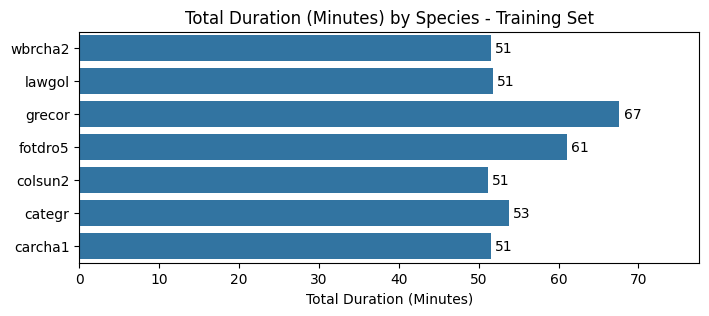

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,3))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='tr'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='tr']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Training Set')

plt.show()

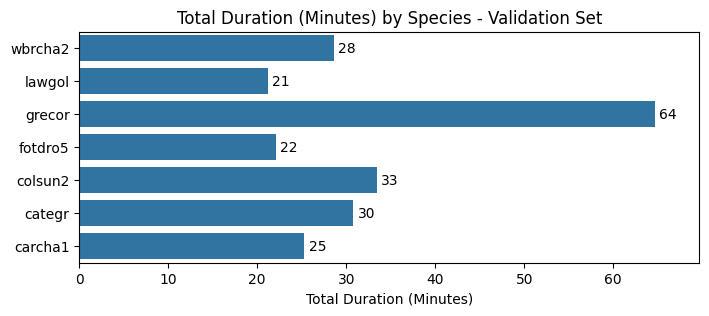

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,3))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='val'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='val']['duration_mins']) + 5])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Validation Set')

plt.show()

In [37]:
split_train.to_csv('C:/Users/thato/Documents/Final-Year-Project/Project-V1/train_val_7.csv', index=False)

# Barebones model

### Feature extraction

In [41]:
npy_filenames = split_train['filename_npy'].values
species_labels = split_train['primary_label'].values
npy_path = 'C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy/'

In [42]:
npy_filenames[0]

'fotdro5/XC412171.npy'

In [39]:
# Function to convert audio numpy array to mel spectrogram
def get_mel_spectrogram(npy_file, sr=sr, n_mels=128, hop_length=512):
    audio_data = np.load(npy_file) 
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

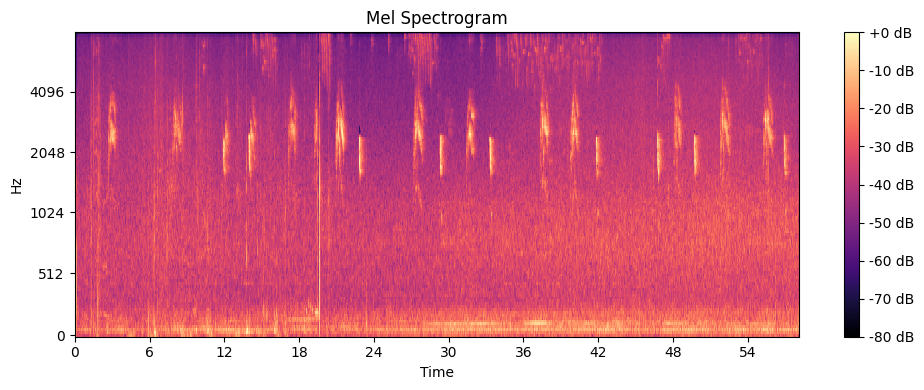

In [44]:
# Plot an example of Mel spectrogram
example_npy = npy_path + npy_filenames[0]
mel_spectrogram_db = get_mel_spectrogram(example_npy)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel') #cmap=viridis
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# Preparing Data for CNN